# Homework 4

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import numpy as np
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Student details

+ **First Name:** Hannah
+ **Last Name:** Moskios
+ **Email:** hmoskios@purdue.edu

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file and then manually upload it on Google Colab. The easiest way is to click on the folder icon on the left of the browser window and click on the upload button (or drag and drop the file). Some other options are [here](https://colab.research.google.com/notebooks/io.ipynb).
+ Downloading the file to the working directory of this notebook with this code:

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [ ]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces, and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force, they marked the stress (force be unit area) in the middle of the material and the corresponding strain of the material (percent elongation in the pulling direction).
- Eventually, the material entered the plastic regime and broke.
Here is a visualization of the data:

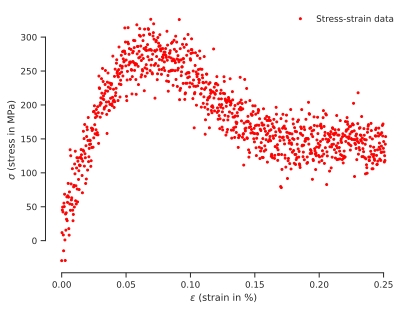

In [ ]:
# Strain
x = data[:, 0]
# Stress in MPa
y = data[:, 1]

plt.figure()
plt.plot(
    x,
    y,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Note that you don't necessarily get a unique stress for each particular value of the strain.
This is because the atoms are jiggling around due to thermal effects.
So, there is always this "jiggling" noise when measuring the stress and the strain.
We want to process this noise to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the material, affected by the fine structure, e.g., the chemical bonds, the crystalline structure, any defects, etc.
It is a required input to the mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

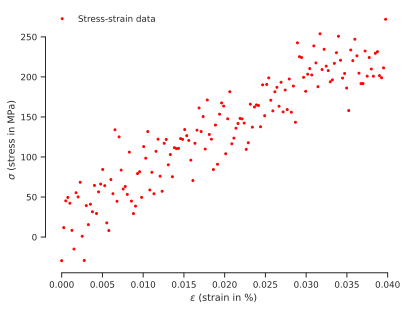

In [ ]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of stresses/strains)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]

# Visualize to make sure you have the right data
plt.figure()
plt.plot(
    x_rel,
    y_rel,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Split your data into training and validation.

**Hint:** You may use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.

In [ ]:
# Split the data into training and validation datasets
# Hint: Consult the lecture notes
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    x_rel, y_rel, test_size=0.33, random_state=42)  # Your code

Use the following to visualize your split:

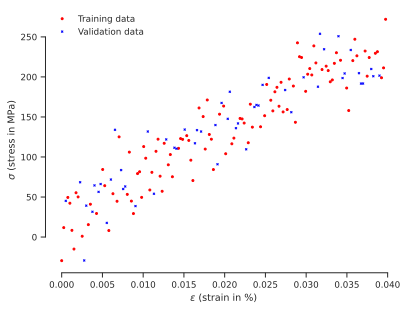

In [ ]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

In [ ]:
# Your code here

# Design matrix:
# Want to fit a linear model where the intercept is 0
# Therefore, the polynomial model should not include the constant term
# Construct a design matrix with only the 1st-degree terms (x_train)
Phi_train = x_train.reshape(-1, 1)

# Evidence approximation
from sklearn.linear_model import BayesianRidge
model = BayesianRidge(fit_intercept=False).fit(Phi_train, y_train)

# Compute noise variance and precision of the weights
sigma = np.sqrt(1 / model.alpha_)
alpha = model.lambda_
print(f"Noise variance and precision of the weights:")
print(f"sigma = {sigma:.2f} --> sigma^2 = {sigma ** 2:.2f}")
print(f"alpha = {alpha:.10f}\n")

# Compute the hyperparameters
print("Hyperparameters (these are the default values for BayesianRidge):")
print(f"alpha_1 = {model.get_params()['alpha_1']}")
print(f"alpha_2 = {model.get_params()['alpha_2']}")
print(f"lambda_1 = {model.get_params()['lambda_1']}")
print(f"lambda_2 = {model.get_params()['lambda_2']}")

Noise variance and precision of the weights:
sigma = 27.49 --> sigma^2 = 755.86
alpha = 0.0000000241

Hyperparameters (these are the default values for BayesianRidge):
alpha_1 = 1e-06
alpha_2 = 1e-06
lambda_1 = 1e-06
lambda_2 = 1e-06


### Subpart A.III
Calculate the mean square error of the validation data.

In [ ]:
# your code here
# Design matrix for the validation data
Phi_valid = x_valid.reshape(-1, 1)

# Compute the MSE
y_valid_predict, y_valid_std = model.predict(Phi_valid, return_std=True)
MSE = np.mean((y_valid_predict - y_valid) ** 2)
print(f"Mean Squared Error (MSE) = {MSE:.2f}\n")

# Calculate the RMSE (relative MSE)
mu = y_train.mean()
MSE_simplest = np.mean((y_valid - mu) ** 2)
RMSE = MSE / MSE_simplest
print(f'Relative Mean Squared Error (RMSE) = {RMSE:1.2f}')

Mean Squared Error (MSE) = 1108.02

Relative Mean Squared Error (RMSE) = 0.25


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

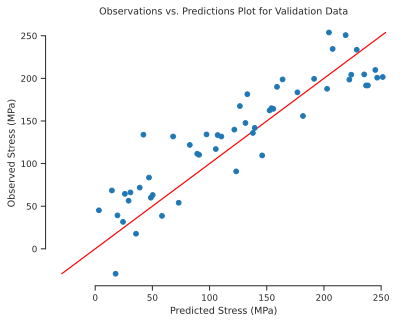

In [ ]:
# your code here
fig, ax = plt.subplots()
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-')
ax.plot(y_valid_predict, y_valid,'o')
ax.set_xlabel('Predicted Stress (MPa)')
ax.set_ylabel('Observed Stress (MPa)')
ax.set_title('Observations vs. Predictions Plot for Validation Data')
sns.despine(trim=True);

### Subpart A.V
Compute and plot the standardized errors for the validation data.

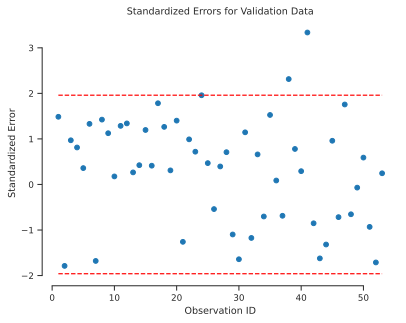

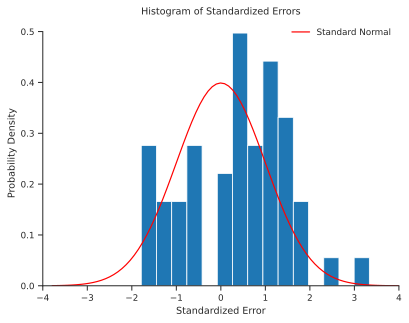

In [ ]:
# your code here
# Compute the standardized errors and the observation indices
eps = (y_valid - y_valid_predict) / y_valid_std
idx = np.arange(1, eps.shape[0] + 1)

# Plot the standardized errors
fig, ax = plt.subplots()
ax.plot(idx, eps, 'o')
ax.plot(idx, 1.96 * np.ones(eps.shape), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape), 'r--')
ax.set_xlabel('Observation ID')
ax.set_ylabel('Standardized Error')
ax.set_title('Standardized Errors for Validation Data')
sns.despine(trim=True);

# Histogram of standardized errors
fig, ax = plt.subplots()
ax.hist(eps, bins=15, density=True)
sample_points = np.linspace(eps.min() - 2, eps.max() + 2, 100)
ax.plot(sample_points, st.norm.pdf(sample_points),'r-', label='Standard Normal')
ax.set_xlabel('Standardized Error')
ax.set_ylabel('Probability Density')
ax.set_title('Histogram of Standardized Errors')
ax.set_xlim(-4, 4)
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

### Subpart A.VI
Make the quantile-quantile plot of the standardized errors.

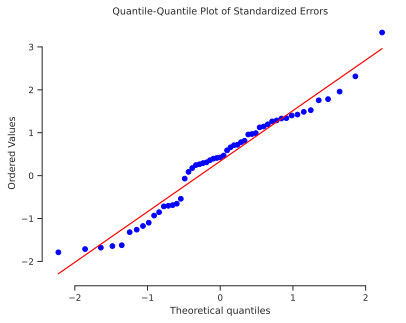

In [ ]:
# your code here
fig, ax = plt.subplots()
st.probplot(eps, dist='norm', plot=ax)
ax.set_title('Quantile-Quantile Plot of Standardized Errors')
sns.despine(trim=True);

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

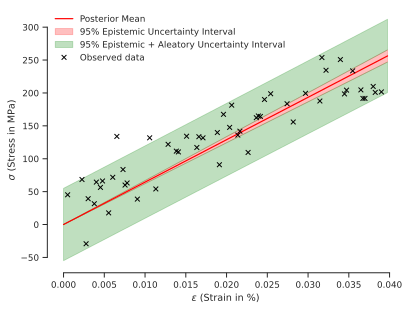

In [ ]:
# your code here
# Make predictions using the model
xx = np.linspace(x_rel.min(), x_rel.max(), 100)
yy_mean, yy_measured_std = model.predict(xx.reshape(-1, 1), return_std=True)

# Find the epistemic predictive standard deviation
yy_std = np.sqrt(yy_measured_std ** 2 - sigma ** 2)

# 95% epistemic uncertainty interval bounds
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std

# 95% epistemic + aleatory uncertainty interval bounds
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

# Create the plot
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label='Posterior Mean')
ax.fill_between(
        xx,
        yy_le,
        yy_ue,
        color='red',
        alpha=0.25,
        label="95% Epistemic Uncertainty Interval"
    )
ax.fill_between(
        xx,
        yy_lae,
        yy_le,
        color='green',
        alpha=0.25
    )
ax.fill_between(
        xx,
        yy_ue,
        yy_uae,
        color='green',
        alpha=0.25,
        label="95% Epistemic + Aleatory Uncertainty Interval"
    )
ax.plot(x_valid, y_valid, 'kx', label='Observed data')
ax.set_xlabel('$\epsilon$ (Strain in %)')
ax.set_ylabel('$\sigma$ (Stress in MPa)')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

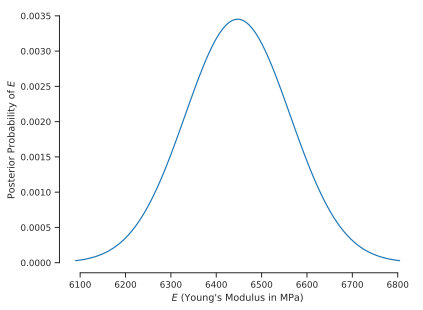

In [ ]:
# your code here
# Posterior mean of the weights
m = model.coef_

# Posterior covariance matrix for the weights
S = model.sigma_

# Create a normal random variable
E_post = st.norm(loc=m, scale=np.sqrt(S[0, 0]))

# Plot the posterior of E
fig, ax = plt.subplots()
E_vals = np.linspace(E_post.ppf(0.001), E_post.ppf(0.999), 100)
ax.plot(E_vals, E_post.pdf(E_vals))
ax.set_xlabel("$E$ (Young's Modulus in MPa)")
ax.set_ylabel('Posterior Probability of $E$')
sns.despine(trim=True);

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

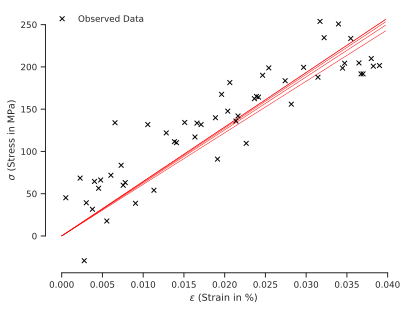

In [ ]:
# your code here
# Plot the samples
fig, ax = plt.subplots()
for _ in range(5):
  E_samples = E_post.rvs()
  yy_sample = E_samples * xx
  ax.plot(xx, yy_sample, 'r', lw=0.5)

# Plot the observed data on top of the samples
ax.plot(x_valid, y_valid, 'kx', label='Observed Data')
ax.set_xlabel('$\epsilon$ (Strain in %)')
ax.set_ylabel('$\sigma$ (Stress in MPa)')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

In [ ]:
# your code here
E_lb = E_post.ppf(0.025)
E_ub = E_post.ppf(0.975)
print(f"95% Credible Interval for E = [{E_lb[0]:.2f} MPa, {E_ub[0]:.2f} MPa]")

95% Credible Interval for E = [6220.71 MPa, 6673.61 MPa]


### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [ ]:
# your code here
E_chosen = E_post.mean()
print(f"Chosen value for E = {E_chosen[0]:.2f} MPa.")
print(f"I would choose this value because it is has the highest probability.")

Chosen value for E = 6447.16 MPa.
I would choose this value because it is has the highest probability.


Since $E$ is a normally distributed variable, its mean, median, and mode are all the same. Furthermore, the mean/median/mode is the maximum of the posterior. Therefore, if I had to pick a single value for $E$, I would choose the mean/median/mode. This equates to a value of $E = 6447.16$ MPa.

## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We want to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [ ]:
# your code here - Repeat as many text and code blocks as you like
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.33, random_state=42)  # Your code

Use the following to visualize your split:

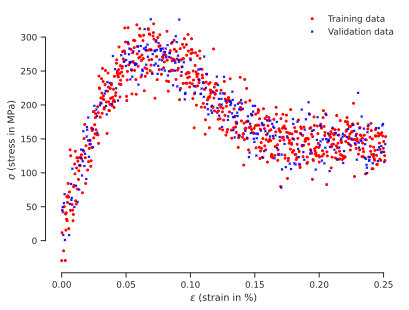

In [ ]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model to capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ It is linear in the parameters to be estimated,
+ It has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We will use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime, and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &=
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

We include the first derivative because we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other
parameters.
I am going to spare you the details.
The result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [ ]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """Compute the design matrix for the stress-strain curve problem.

    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.

    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = Epsilon  # Your code here
    for i in range(2, d+1):
        Phi[:, i-1] = ((i - 1) * epsilon_l ** i
                       - i * Epsilon * epsilon_l ** (i - 1)
                       + Epsilon ** i) * Step  # Your code here
    return Phi

Visualize the basis functions here:

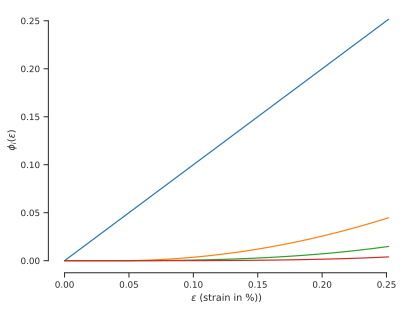

In [ ]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$')
sns.despine(trim=True);

### Subpart B.III

Fit the model using automatic relevance determination and demonstrate that it works well by doing everything we did above (MSE, observations vs. predictions plot, standardized errors, etc.).

In [ ]:
# Your code here - Use as many blocks as you need!
from sklearn.linear_model import ARDRegression
Phi_train = compute_design_matrix(x_train, epsilon_l, d)

# Just call the resulting model "model"
model = ARDRegression(fit_intercept=False).fit(Phi_train, y_train)

Compute the MSE:

In [ ]:
# Calculate the MSE
Phi_valid = compute_design_matrix(x_valid, epsilon_l, d)
y_valid_predict, y_valid_std = model.predict(Phi_valid, return_std=True)
MSE = np.mean((y_valid_predict - y_valid) ** 2)
print(f"Mean Squared Error (MSE) = {MSE:.2f}\n")

# Calculate the RMSE (relative MSE)
mu = y_train.mean()
MSE_simplest = np.mean((y_valid - mu) ** 2)
RMSE = MSE / MSE_simplest
print(f'Relative Mean Squared Error (RMSE) = {RMSE:1.2f}')

Mean Squared Error (MSE) = 685.65

Relative Mean Squared Error (RMSE) = 0.17


Create the observations vs. predictions plot:

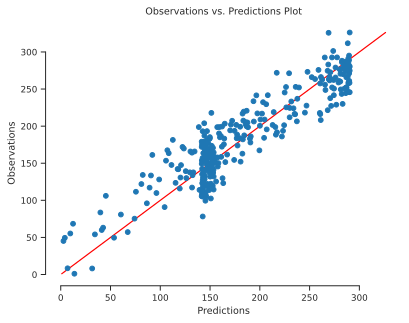

In [ ]:
# Observations vs. predictions plot
fig, ax = plt.subplots()
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-')
ax.plot(y_valid_predict, y_valid,'o')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
ax.set_title('Observations vs. Predictions Plot')
sns.despine(trim=True);

Create the standardized errors plot:

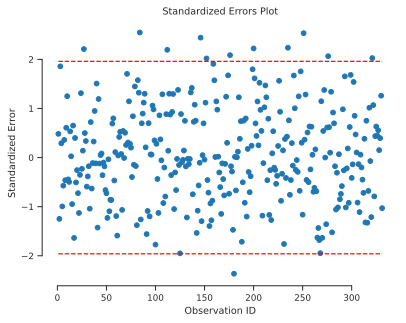

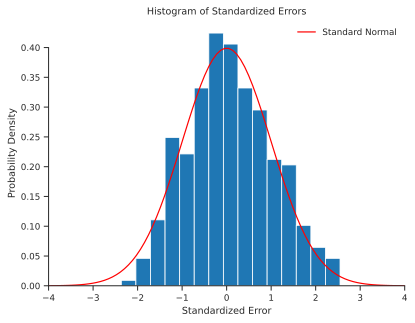

In [ ]:
# Standardized errors plot
# Compute the standardized errors and the observation indices
std_errors = (y_valid - y_valid_predict) / y_valid_std
idx = np.arange(1, std_errors.shape[0] + 1)

# Plot the standardized errors
fig, ax = plt.subplots()
ax.plot(idx, std_errors, 'o')
ax.plot(idx, 1.96 * np.ones(std_errors.shape), 'r--')
ax.plot(idx, -1.96 * np.ones(std_errors.shape), 'r--')
ax.set_xlabel('Observation ID')
ax.set_ylabel('Standardized Error')
ax.set_title('Standardized Errors Plot')
sns.despine(trim=True);

# Histogram of standardized errors
fig, ax = plt.subplots()
ax.hist(std_errors, bins=15, density=True)
sample_points = np.linspace(std_errors.min() - 2, std_errors.max() + 2, 100)
ax.plot(sample_points, st.norm.pdf(sample_points),'r-', label='Standard Normal')
ax.set_xlabel('Standardized Error')
ax.set_ylabel('Probability Density')
ax.set_title('Histogram of Standardized Errors')
ax.set_xlim(-4, 4)
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

Create the quantile-quantile plot:

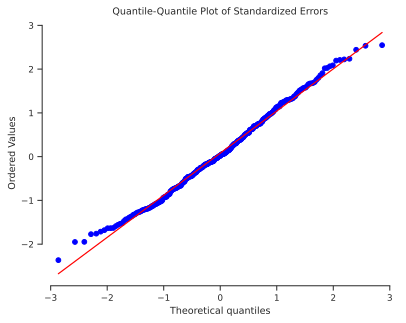

In [ ]:
# Quantile-quantile plot
fig, ax = plt.subplots()
st.probplot(std_errors, dist='norm', plot=ax)
ax.set_title('Quantile-Quantile Plot of Standardized Errors')
sns.despine(trim=True);

According to the above analysis, the fitted model seems to work well. The RMSE is smaller than 1 (and it is very close to 0). On the observations vs. predictions plot, the validation data closely aligns with the red line. On the standardized errors plot, the large majority of the data points fall within the 95% uncertainty interval. On the quantile-quantile plot, the data points closely hug the red line.

### Subpart B.IV
Visualize the epistemic and aleatory uncertainty in the stress-strain relation.

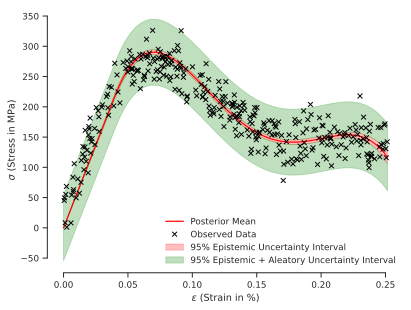

In [ ]:
# Your code here
sigma = np.sqrt(1 / model.alpha_)
xx = np.linspace(0, x.max(), 100)
Phi_xx = compute_design_matrix(xx, epsilon_l, d)
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma ** 2)

# 95% epistemic uncertainty interval bounds
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std

# 95% epistemic + aleatory uncertainty interval bounds
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

# Plot
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label='Posterior Mean')
ax.plot(x_valid, y_valid, 'kx', label='Observed Data')
ax.fill_between(
        xx,
        yy_le,
        yy_ue,
        color='red',
        alpha=0.25,
        label="95% Epistemic Uncertainty Interval"
    )
ax.fill_between(
        xx,
        yy_lae,
        yy_le,
        color='green',
        alpha=0.25
    )
ax.fill_between(
        xx,
        yy_ue,
        yy_uae,
        color='green',
        alpha=0.25,
        label="95% Epistemic + Aleatory Uncertainty Interval"
    )
ax.set_xlabel('$\epsilon$ (Strain in %)')
ax.set_ylabel('$\sigma$ (Stress in MPa)')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

### Subpart B.V - Extract the ultimate strength

Now, you will quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize the posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
 + Sample from the posterior of the weights of your model
 + For each sample, evaluate the stresses at the dense set of strain points defined earlier
 + For each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

95% Credible Interval for Ultimate Strength = [286.35 MPa, 294.23 MPa]
Chosen Value for Ultimate Strength = 290.36 MPa


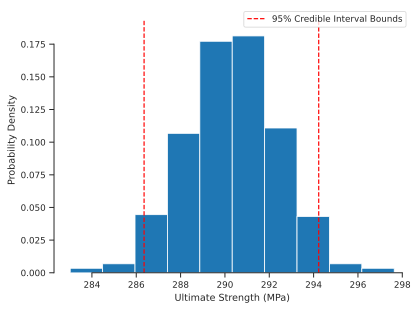

In [ ]:
# Enter your code here
# Posterior mean and covariance matrix of the weights
m = model.coef_
S = model.sigma_

# Posterior of the weights
w_post = st.multivariate_normal(mean=m, cov=S)

# Number of samples to take
num_samples = 1000

# Sample the posterior of weights, compute the stresses, and find the maximum
ultimate_strength_post_samples = np.ndarray((num_samples,))
for i in range(num_samples):
  w_sample = w_post.rvs()
  yy_sample = np.dot(Phi_xx, w_sample)
  ultimate_strength_post_samples[i] = np.max(yy_sample)

# Visualize the posterior of the utimate strength using a histogram
fig, ax = plt.subplots()
ax.hist(ultimate_strength_post_samples, bins=10, density=True)
ax.set_xlabel('Ultimate Strength (MPa)')
ax.set_ylabel('Probability Density')
sns.despine(trim=True);

# 95% credible interval for the ultimate strength
mu_025 = np.quantile(ultimate_strength_post_samples, 0.025)
mu_975 = np.quantile(ultimate_strength_post_samples, 0.975)
print(f"95% Credible Interval for Ultimate Strength = [{mu_025:.2f} MPa, {mu_975:.2f} MPa]")

# Plot the 95% credible interval bounds
mean_strength = np.mean(ultimate_strength_post_samples)
norm_strength = st.norm(loc=mean_strength,
                        scale=ultimate_strength_post_samples.std())
pdf_mean = norm_strength.pdf(mean_strength)
ax.vlines([mu_025, mu_975], 0, pdf_mean, 'r',
          linestyles='--', label='95% Credible Interval Bounds')
ax.legend(loc='best', frameon=True)

# Pick a value for the ultimate strength (median value)
ult_strength_chosen = np.quantile(ultimate_strength_post_samples, 0.5)
print(f"Chosen Value for Ultimate Strength = {ult_strength_chosen:.2f} MPa")

Note: The chosen value for the ultimate strength is the median value (290.36 MPa). This is because the median falls exactly in the center of the 95% credible interval. Half of the posterior falls above the median, while the other half is below. Therefore, the median is a good representation of the ultimate strength value.

# Problem 2 - Optimizing the performance of a compressor

In this problem, we will need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google Drive or just download it with the code segment below:

In [ ]:
url = "https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/lecturebook/data/compressor_data.xlsx"
!curl -O $url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14771  100 14771    0     0  67227      0 --:--:-- --:--:-- --:--:-- 67140


Note that this is an Excel file, so we need pandas to read it.
Here is how:

In [ ]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
0,-30,11,25,8,35,60,28.8,8.000000,1557,901,4.4,1.73,0.467
1,-30,11,30,8,35,60,23.0,6.388889,1201,881,4.0,1.36,0.425
2,-30,11,35,8,35,60,17.9,4.972222,892,858,3.7,1.04,0.382
3,-25,11,25,8,35,60,46.4,12.888889,2509,1125,5.3,2.23,0.548
4,-25,11,30,8,35,60,40.2,11.166667,2098,1122,5.1,1.87,0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,10,11,45,8,35,60,245.2,68.111111,12057,2525,11.3,4.78,0.722
61,10,11,50,8,35,60,234.1,65.027778,10939,2740,12.3,3.99,0.719
62,10,11,55,8,35,60,222.2,61.722222,9819,2929,13.1,3.35,0.709
63,10,11,60,8,35,60,209.3,58.138889,8697,3091,13.7,2.81,0.693


The data are part of an experimental study of a variable-speed reciprocating compressor.
The experimentalists varied two temperatures, $T_e$ and $T_c$ (both in C), and they measured various other quantities.
We aim to learn the map between $T_e$ and $T_c$ and measure Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [ ]:
# Here is how to extract T_e and T_c columns and put them in a numpy array
x = data[['T_e','T_c']].values
x

array([[-30,  25],
       [-30,  30],
       [-30,  35],
       [-25,  25],
       [-25,  30],
       [-25,  35],
       [-25,  40],
       [-25,  45],
       [-20,  25],
       [-20,  30],
       [-20,  35],
       [-20,  40],
       [-20,  45],
       [-20,  50],
       [-15,  25],
       [-15,  30],
       [-15,  35],
       [-15,  40],
       [-15,  45],
       [-15,  50],
       [-15,  55],
       [-10,  25],
       [-10,  30],
       [-10,  35],
       [-10,  40],
       [-10,  45],
       [-10,  50],
       [-10,  55],
       [-10,  60],
       [ -5,  25],
       [ -5,  30],
       [ -5,  35],
       [ -5,  40],
       [ -5,  45],
       [ -5,  50],
       [ -5,  55],
       [ -5,  60],
       [ -5,  65],
       [  0,  25],
       [  0,  30],
       [  0,  35],
       [  0,  40],
       [  0,  45],
       [  0,  50],
       [  0,  55],
       [  0,  60],
       [  0,  65],
       [  5,  25],
       [  5,  30],
       [  5,  35],
       [  5,  40],
       [  5,  45],
       [  5,

In [ ]:
# Here is how to extract the Capacity
y = data['Capacity'].values
y

array([ 1557,  1201,   892,  2509,  2098,  1726,  1398,  1112,  3684,
        3206,  2762,  2354,  1981,  1647,  5100,  4547,  4019,  3520,
        3050,  2612,  2206,  6777,  6137,  5516,  4915,  4338,  3784,
        3256,  2755,  8734,  7996,  7271,  6559,  5863,  5184,  4524,
        3883,  3264, 10989, 10144,  9304,  8471,  7646,  6831,  6027,
        5237,  4461, 13562, 12599, 11633, 10668,  9704,  8743,  7786,
        6835,  5891, 16472, 15380, 14279, 13171, 12057, 10939,  9819,
        8697,  7575])

Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to ensure your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

## Part A - Fit the capacity

### Subpart A.I

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [ ]:
# your code here - Repeat as many text and code blocks as you like
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ARDRegression

# Split the data into training data and validation data
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.33)  # Your code

# Design matrix for training data
poly = PolynomialFeatures(degree=3)
Phi_train = poly.fit_transform(x_train)

# Fit the model using automatic relevance determination (ARD)
model = ARDRegression(fit_intercept=False).fit(Phi_train, y_train)

In [ ]:
# Calculate the MSE
Phi_valid = poly.fit_transform(x_valid)
y_valid_predict, y_valid_std = model.predict(Phi_valid, return_std=True)
MSE = np.mean((y_valid_predict - y_valid) ** 2)
print(f"MSE = {MSE:.2f}")

# Calculate the RMSE (relative MSE)
mu = y_train.mean()
MSE_simplest = np.mean((y_valid - mu) ** 2)
RMSE = MSE / MSE_simplest
print(f'RMSE = {RMSE:.6f}')

MSE = 1101.68
RMSE = 0.000096


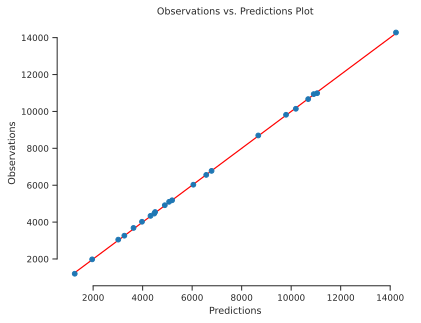

In [ ]:
# Observations vs. predictions plot
fig, ax = plt.subplots()
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-')
ax.plot(y_valid_predict, y_valid,'o')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
ax.set_title('Observations vs. Predictions Plot')
sns.despine(trim=True);

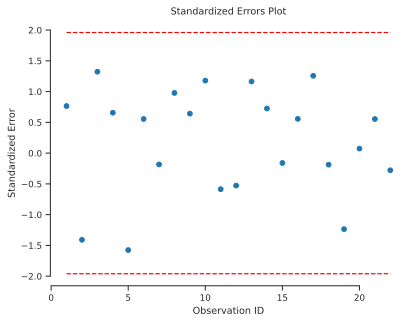

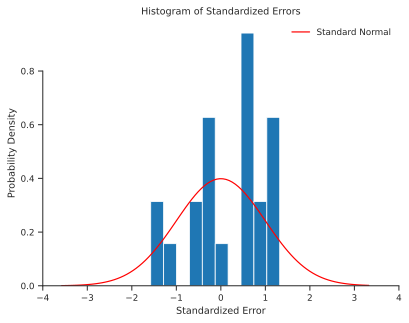

In [ ]:
# Standardized errors plot
# Compute the standardized errors
std_errors = (y_valid - y_valid_predict) / y_valid_std
idx = np.arange(1, std_errors.shape[0] + 1)

# Make the plot
fig, ax = plt.subplots()
ax.plot(idx, std_errors, 'o')
ax.plot(idx, 1.96 * np.ones(std_errors.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(std_errors.shape[0]), 'r--')
ax.set_xlabel('Observation ID')
ax.set_ylabel('Standardized Error')
ax.set_title('Standardized Errors Plot')
sns.despine(trim=True);

# Histogram of standardized errors
fig, ax = plt.subplots()
ax.hist(std_errors, bins=10, density=True)
sample_points = np.linspace(std_errors.min() - 2, std_errors.max() + 2, 100)
ax.plot(sample_points, st.norm.pdf(sample_points),'r-', label='Standard Normal')
ax.set_xlabel('Standardized Error')
ax.set_ylabel('Probability Density')
ax.set_title('Histogram of Standardized Errors')
ax.set_xlim(-4, 4)
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

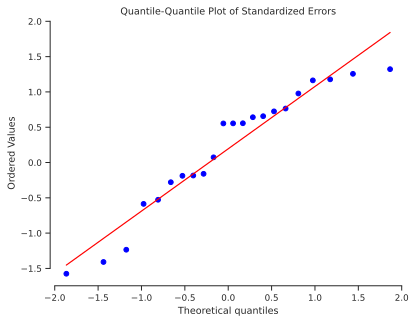

In [ ]:
# Quantile-quantile plot
fig, ax = plt.subplots()
st.probplot(std_errors, dist='norm', plot=ax)
ax.set_title('Quantile-Quantile Plot of Standardized Errors')
sns.despine(trim=True);

According to the above analysis, the fitted model appears to work well. For example, the RMSE is smaller than 1 (and it is very close to 0). On the observations vs. predictions plot, the validation data closely aligns with the red line. On the standardized errors plot, all the data points fall within the 95% uncertainty interval for $N(0,1)$. The histogram of the standardized errors is also relatively close to a normal distribution. Lastly, the quantile-quantile plot shows that the empirical quantiles are relatively close the theoretical quantiles of the standardized errors.

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [ ]:
# your code here
sigma2 = 1 / model.alpha_
sigma = np.sqrt(sigma2)
print(f"sigma = {sigma:.2f}")
print(f"sigma^2 = {sigma2:.2f}")

sigma = 34.71
sigma^2 = 1204.76


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

Prior w precision = alpha = [0.00, 0.00, 0.00, 0.03, 0.14, 20.17, 36294.66, 1163.38, 1010.15, 10038.97]
Posterior w mean = m = [15517.977, 568.298, -184.182, 6.280, -2.670, 0.218, 0.000, -0.029, -0.031, 0.000]



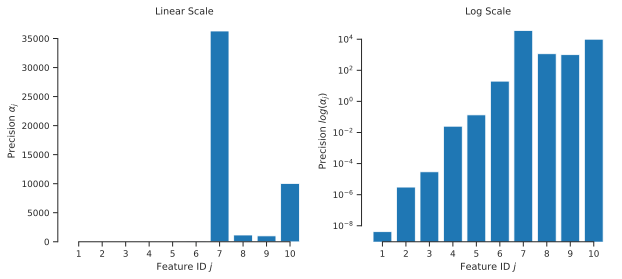

In [ ]:
# your code here
# Find the precision corresponding to each weight
alpha = model.lambda_
print(f"Prior w precision = alpha = [{', '.join(f'{a:.2f}' for a in alpha)}]")

# Plot the precision for each basis function on a linear scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(np.arange(1, Phi_train.shape[1] + 1), alpha)
ax1.set_xlabel("Feature ID $j$")
ax1.set_ylabel(r"Precision $\alpha_j$")
ax1.set_xticks(np.arange(1, Phi_train.shape[1] + 1))
ax1.set_title("Linear Scale")
sns.despine(trim=True);

# Plot the precision for each basis function on a log scale
ax2.bar(np.arange(1, Phi_train.shape[1] + 1), alpha)
ax2.set_xlabel("Feature ID $j$")
ax2.set_ylabel(r"Precision $log(\alpha_j$)")
ax2.set_xticks(np.arange(1, Phi_train.shape[1] + 1))
ax2.set_yscale("log")
ax2.set_title("Log Scale")
sns.despine(trim=True);

# Find the posterior mean of the weights
m = model.coef_
print(f"Posterior w mean = m = [{', '.join(f'{a:.3f}' for a in m)}]\n")

The larger the precision ($\alpha_j$) of a weight, the more its prior (and posterior) concentrate around zero. When the precision is large, this means the corresponding basis function can be safely removed from the model. Let's set the precision threshold to 100. If the precision for a feature is above the threshold, then it can be removed.

According to the above plot, features 7, 8, 9, and 10 have a large precision (above 100) and can therefore be excluded from the model. In contrast, features 1, 2, 3, 4, 5, and 6 have small $\alpha$-values (below 100), making them the most important for predicting capacity.

Additionally, we can evaluate the posterior mean of the weights. The posterior mean of the weights for features 7, 8, 9, and 10 are very close to zero. This further confirms that these features can be excluded from the model.

The original model includes features 1-10:

$y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon$

After eliminating the unnecessary features, the new model becomes:

$y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + \epsilon$

## Part B - Fit the Power

### Subpart B.I

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [ ]:
# your code here - Repeat as many text and code blocks as you like
# Here is how to extract the power
y = data['Power'].values
y

array([ 901,  881,  858, 1125, 1122, 1114, 1099, 1075, 1323, 1343, 1356,
       1361, 1354, 1335, 1484, 1534, 1576, 1606, 1624, 1628, 1615, 1600,
       1687, 1764, 1827, 1876, 1909, 1923, 1917, 1663, 1794, 1911, 2014,
       2101, 2169, 2217, 2243, 2246, 1663, 1844, 2010, 2159, 2290, 2400,
       2489, 2554, 2593, 1593, 1830, 2051, 2252, 2434, 2594, 2729, 2839,
       2922, 1442, 1743, 2025, 2286, 2525, 2740, 2929, 3091, 3223])

In [ ]:
# Split the data into training data and validation data
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.33, random_state=42)  # Your code

# Design matrix for training data
poly = PolynomialFeatures(degree=3)
Phi_train = poly.fit_transform(x_train)

# Fit the model using automatic relevance determination (ARD)
model = ARDRegression(fit_intercept=False).fit(Phi_train, y_train)

In [ ]:
# Calculate the MSE
Phi_valid = poly.fit_transform(x_valid)
y_valid_predict, y_valid_std = model.predict(Phi_valid, return_std=True)
MSE = np.mean((y_valid_predict - y_valid) ** 2)
print(f"MSE = {MSE:.2f}")

# Calculate the RMSE (relative MSE)
mu = y_train.mean()
MSE_simplest = np.mean((y_valid - mu) ** 2)
RMSE = MSE / MSE_simplest
print(f'RMSE = {RMSE:.6f}')

MSE = 1031.12
RMSE = 0.002293


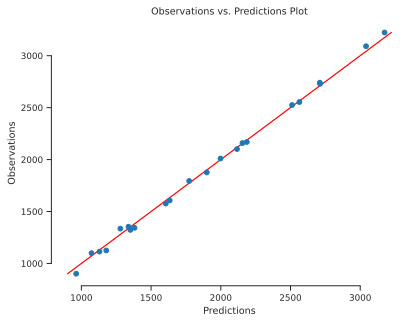

In [ ]:
# Observations vs. predictions plot
fig, ax = plt.subplots()
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-')
ax.plot(y_valid_predict, y_valid,'o')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
ax.set_title('Observations vs. Predictions Plot')
sns.despine(trim=True);

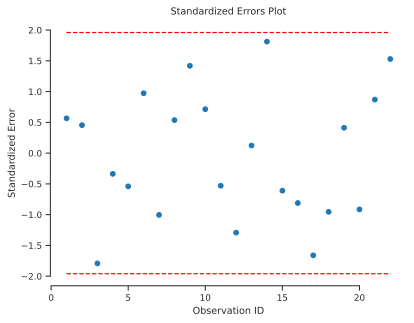

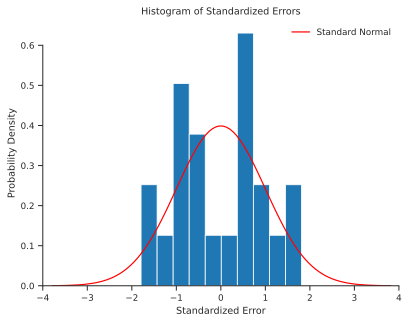

In [ ]:
# Standardized errors plot
# Compute the standardized errors
std_errors = (y_valid - y_valid_predict) / y_valid_std
idx = np.arange(1, std_errors.shape[0] + 1)

# Make the plot
fig, ax = plt.subplots()
ax.plot(idx, std_errors, 'o')
ax.plot(idx, 1.96 * np.ones(std_errors.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(std_errors.shape[0]), 'r--')
ax.set_xlabel('Observation ID')
ax.set_ylabel('Standardized Error')
ax.set_title('Standardized Errors Plot')
sns.despine(trim=True);

# Histogram of standardized errors
fig, ax = plt.subplots()
ax.hist(std_errors, bins=10, density=True)
sample_points = np.linspace(std_errors.min() - 2, std_errors.max() + 2, 100)
ax.plot(sample_points, st.norm.pdf(sample_points),'r-', label='Standard Normal')
ax.set_xlabel('Standardized Error')
ax.set_ylabel('Probability Density')
ax.set_title('Histogram of Standardized Errors')
ax.set_xlim(-4, 4)
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

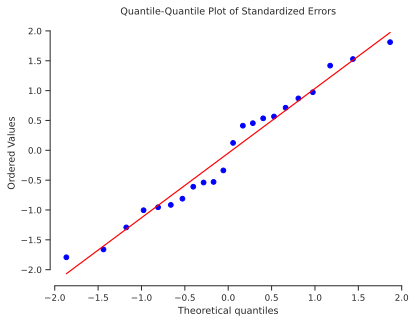

In [ ]:
# Quantile-quantile plot
fig, ax = plt.subplots()
st.probplot(std_errors, dist='norm', plot=ax)
ax.set_title('Quantile-Quantile Plot of Standardized Errors')
sns.despine(trim=True);

According to the above analysis, the fitted model appears to work well. For example, the RMSE is smaller than 1 (and it is very close to 0). On the observations vs. predictions plot, the validation data closely aligns with the red line. On the standardized errors plot, all the data points fall within the 95% uncertainty interval for $N(0,1)$. The histogram of the standardized errors also seems to follow a normal distribution. Lastly, the quantile-quantile plot shows that the empirical quantiles closely match the theoretical quantiles of the standardized errors.

### Subpart B.II

What is the noise variance you estimated for the Power?

In [ ]:
# your code here
sigma2 = 1 / model.alpha_
sigma = np.sqrt(sigma2)
print(f"sigma = {sigma:.2f}")
print(f"sigma^2 = {sigma ** 2:.2f}")

sigma = 28.00
sigma^2 = 783.96


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

Prior w precision = alpha = [0.00, 0.00, 0.00, 1.37, 0.34, 5.10, 186030.38, 138336.61, 41396.25, 35180.58]
Posterior w mean = m = [278.877, -46.660, 64.574, -0.852, 1.717, -0.442, 0.000, 0.000, 0.000, 0.000]


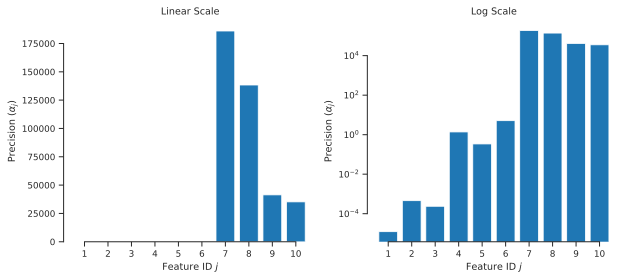

In [ ]:
# your code here
# Find the precision corresponding to each weight
alpha = model.lambda_
print(f"Prior w precision = alpha = [{', '.join(f'{a:.2f}' for a in alpha)}]")

# Plot the precision for each basis function on a linear scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(np.arange(1, Phi_train.shape[1] + 1), alpha)
ax1.set_xlabel("Feature ID $j$")
ax1.set_ylabel(r"Precision ($\alpha_j$)")
ax1.set_xticks(np.arange(1, Phi_train.shape[1] + 1))
ax1.set_title("Linear Scale")
sns.despine(trim=True);

# Plot the precision for each basis function on a log scale
ax2.bar(np.arange(1, Phi_train.shape[1] + 1), alpha)
ax2.set_xlabel("Feature ID $j$")
ax2.set_ylabel(r"Precision ($\alpha_j$)")
ax2.set_xticks(np.arange(1, Phi_train.shape[1] + 1))
ax2.set_yscale("log")
ax2.set_title("Log Scale")
sns.despine(trim=True);

# Find the posterior mean of the weights
m = model.coef_
print(f"Posterior w mean = m = [{', '.join(f'{a:.3f}' for a in m)}]")

Let's set the precision threshold to 100. If the precision for a feature is above the threshold, then it can be removed. According to the above plot, features 7, 8, 9, and 10 have a large precision (above 100) and can therefore be excluded from the model. In contrast, features 1, 2, 3, 4, 5, and 6 have small $\alpha$-values, making them the most important for predicting capacity.

Additionally, we can evaluate the posterior mean of the weights. The posterior mean of the weights for features 7, 8, 9, and 10 are all zero. This further confirms that these features can be excluded from the model.

The original model includes features 1-10:

$y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon$

After eliminating the unnecessary features, the new model becomes:

$y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + \epsilon$

# Problem 3 - Explaining the Challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced to the rubber O-rings, which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propellant through the nozzles, thus producing thrust).

The performance of the O-ring material was sensitive to the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google Drive or run the code cell below).

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

Even though this is a CSV file, you should load it with pandas because it contains some special characters.

In [ ]:
raw_data = pd.read_csv('challenger_data.csv')
raw_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We will use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before proceeding to the data analysis, let's clean the data up.

First, we drop all the bad records:

In [ ]:
clean_data_0 = raw_data.dropna()
clean_data_0

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


We also don't need the last record. Remember that the temperature on the day of the Challenger accident was 31 degrees F.

In [ ]:
clean_data = clean_data_0[:-1]
clean_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Let's extract the features and the labels:

In [ ]:
x = clean_data['Temperature'].values
x

array([66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70,
       81, 76, 79, 75, 76, 58])

In [ ]:
y = clean_data['Damage Incident'].values.astype(np.float64)
y

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1.])

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Refrain from validating because there is little data.
Just use a simple model so that you don't overfit.

Use the following simple linear model, where $\sigma$ is the sigmoid function: $p(y | x,w) = \sigma (w_0 + w_1x)$. The parameters $w_0$ and $w_1$ are to be determined by the logistic regression model.



In [ ]:
# your code here - Repeat as many text and code blocks as you like
from sklearn.linear_model import LogisticRegression

# Design matrix (ones in the first column, x's in the second column)
X = np.hstack([np.ones((x.shape[0], 1)), x[:, None]])

# Fit the logistic regression model
model = LogisticRegression(penalty=None, fit_intercept=False).fit(X, y)

In [ ]:
# Trained weights of the model
w = model.coef_
print(f"Trained weights = w = [{', '.join(f'{a:.3f}' for a in w[0])}]\n")
print(f"w_0 = {w[0, 0]:.3f}\nw_1 = {w[0, 1]:.3f}")

Trained weights = w = [15.043, -0.232]

w_0 = 15.043
w_1 = -0.232


## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

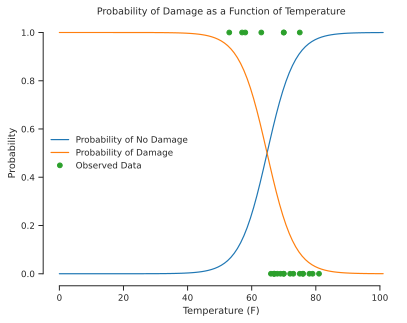

In [ ]:
# your code here
# Array of temperatures
xx = np.linspace(0, x.max() + 20, 101)

# Ones in the first column and temperatures in the second column
XX = np.hstack([np.ones((xx.shape[0], 1)), xx[:, None]])

# Find the probability of damage over the temperature range
predictions_xx = model.predict_proba(XX)

# Plot the probability of damage with the observed data points
fig, ax = plt.subplots()
ax.plot(xx, predictions_xx[:, 0], label="Probability of No Damage")
ax.plot(xx, predictions_xx[:, 1], label='Probability of Damage')
ax.plot(x, y, 'o', label='Observed Data')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Probability')
ax.set_title('Probability of Damage as a Function of Temperature')
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Part C - Decide whether or not to launch

The temperature on the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

In [ ]:
# your code here - Repeat as many text and code blocks as you like
# Compute the probability of damage when the temperature is 31 degrees F
prob_damage_31 = model.predict_proba([[1, 31]])[0, 1]
print(f"Probability of damage at 31 degrees F = {prob_damage_31:.4f}")

Probability of damage at 31 degrees F = 0.9996


When the temperature is 31°F, the probability of damage is 0.9996, or 99.96%. Since the chance of damage is so high, it is likely not a good idea to launch. We will confirm that this is the correct choice using the formal decision-making method below.

First, we must define the cost associated with each decision/prediction pair. If we choose not to launch, we incur costs due to delaying the mission, idle resources, and rescheduling. We also incur the cost of public scrutiny, including loss of confidence from Congress and stakeholders, which could affect future funding opportunities. This cost is assumed to be \$200,000,000. Whether or not there is damage, the cost will always be \$200,000,000 if we do not to launch.

* Cost of not launching when there is no damage = \$200,000,000
* Cost of not launching when there is damage = \$200,000,000

According to [Space Insider](https://spaceinsider.tech/2023/08/16/how-much-does-it-cost-to-launch-a-rocket/#elementor-toc__heading-anchor-6), the launch cost of rockets can vary greatly (between \$1 million and \$4 billion). For this problem, we will assume the launch cost to be \$100,000,000. According to [US News Money](https://money.usnews.com/money/personal-finance/articles/what-is-the-average-american-net-worth-by-age), the average American net worth is roughly \$1,000,000. Since the Challenger had 7 crew members on board, the loss of life would cost \$7,000,000. If we launch and there is damage, we must consider the cost of destroying the shuttle. This cost is assumed to be \$500,000,000.

* Cost of launching when there is no damage = \$100,000,000
* Cost of launching when there is damage = \$100,000,000 + \$7,000,000 + \$500,000,000 = \$607,000,000

In [ ]:
# Cost matrix

# c_00 = cost of not launching (0) when there is no damage (0)
c_00 = 200e6

# c_01 = cost of not launching (0) when there is damage (1)
c_01 = 200e6

# c_10 = cost of launching (1) when there is no damage (0)
c_10 = 100e6

# c_11 = cost of launching (1) when there is damage (1)
c_11 = 607e6

cost_matrix = np.array([[c_00, c_01],
                        [c_10, c_11]])
print(f"Cost Matrix:\n{cost_matrix}")

Cost Matrix:
[[2.00e+08 2.00e+08]
 [1.00e+08 6.07e+08]]


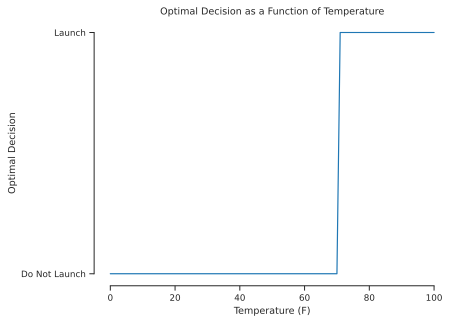

In [ ]:
# Find the probability of damage over the temperature range
xx = np.linspace(0, 100, 101)
XX = np.hstack([np.ones((xx.shape[0], 1)), xx[:, None]])
probs = model.predict_proba(XX)

# Minimize the expected loss
expected_cost = np.einsum('ij,kj->ki', cost_matrix, probs)
decision_idx = np.argmin(expected_cost, axis=1)

# Plot the decision based on the minimization of expected loss
fig, ax = plt.subplots()
ax.plot(xx, decision_idx)
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Optimal Decision')
ax.set_title('Optimal Decision as a Function of Temperature')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Do Not Launch', 'Launch'])
sns.despine(trim=True);

In [ ]:
# Minimum launch temperature
T_min_launch = xx[decision_idx == 1].min()
print(f"Minimum launch temperature = {T_min_launch:.1f}°F")

Minimum launch temperature = 71.0°F


The above plot shows the decision that minimizes the expected loss for various temperatures. When the temperature is below 71°F, we should not launch. When the temperature is above 71°F, we should launch. Therefore, the optimal choice is to not launch when the temperature is 31°F.

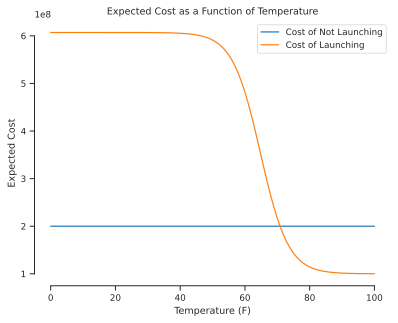

In [ ]:
# Create a plot of expected cost vs. temperature
fig, ax = plt.subplots()
ax.plot(expected_cost[:, 0], label='Cost of Not Launching')
ax.plot(expected_cost[:, 1], label='Cost of Launching')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Expected Cost')
ax.set_title('Expected Cost as a Function of Temperature')
ax.legend(loc='best', frameon=True)
sns.despine(trim=True)

In [ ]:
# Create a table showing the temperatures, costs, and optimal decision
def expected_cost(cost_matrix, prediction_prob):
    """Calculate the expected cost of each decision.

    Arguments
    cost_matrix     --  A D x D matrix. `cost_matrix[i, j]` is the cost
                        of picking `i` and then `j` happens.
    prediction_prob --  An array with D elements containing
                        the probability that each event happens.
    """
    assert cost_matrix.ndim == 2
    D = cost_matrix.shape[0]
    assert cost_matrix.shape[1] == D
    assert prediction_prob.ndim == 1
    assert prediction_prob.shape[0] == D
    res = np.zeros((2,))
    for i in range(2):
        res[i] = (cost_matrix[i, 0] * prediction_prob[0]
                 + cost_matrix[i, 1] * prediction_prob[1])
    return res

print('Temperatures\tCost of Not Launching\tCost of Launching\tChoice')
print('-' * 82)

for i in range(xx.shape[0]):
    exp_c = expected_cost(cost_matrix, predictions_xx[i])
    line = f'{xx[i]:1.1f}\t\t{exp_c[0]:1.0f}'
    tmp = f'\t\t{exp_c[1]:1.0f}'
    launch_decision = None
    if exp_c[0] < exp_c[1]:
        line += '*'
        launch_decision = "\t\tDo Not Launch"
    else:
        tmp += '*'
        launch_decision = "\t\tLaunch"
    line += tmp
    line += launch_decision
    print(line)

Temperatures	Cost of Not Launching	Cost of Launching	Choice
----------------------------------------------------------------------------------
0.0		200000000*		606999851		Do Not Launch
1.0		200000000*		606999812		Do Not Launch
2.0		200000000*		606999763		Do Not Launch
3.0		200000000*		606999700		Do Not Launch
4.0		200000000*		606999620		Do Not Launch
5.0		200000000*		606999520		Do Not Launch
6.0		200000000*		606999393		Do Not Launch
7.0		200000000*		606999233		Do Not Launch
8.0		200000000*		606999030		Do Not Launch
9.0		200000000*		606998774		Do Not Launch
10.0		200000000*		606998450		Do Not Launch
11.0		200000000*		606998041		Do Not Launch
12.0		200000000*		606997523		Do Not Launch
13.0		200000000*		606996868		Do Not Launch
14.0		200000000*		606996040		Do Not Launch
15.0		200000000*		606994994		Do Not Launch
16.0		200000000*		606993671		Do Not Launch
17.0		200000000*		606991999		Do Not Launch
18.0		200000000*		606989885		Do Not Launch
19.0		200000000*		606987212		Do Not Launch
20.0		2